## Pre-trained GloVe on Twitter data

In [1]:
# importing libraries
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
import pandas as pd
import csv
import numpy as np

from statistics import mean
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Constants

In [2]:
TOP_N = 30
KEYS = { \
    "offensive": set(),
    "abusive": set(),
    "cyberbullying": set(), 
    "vulgar": set(), 
    "racist": set(), 
    "homophobic": set(), 
    "profane": set(), 
    "slur": set(), 
    "harrasment": set(), 
    "obscene": set(), 
    "threat": set(), 
    "discredit": set(), 
    "hateful": set(), 
    "insult": set(), 
    "hostile": set(),
    # adding another one - sexist    
    "sexist": set()
}
FIXED_KEYS = list(KEYS.keys())

In [120]:
lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 

for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'offensive': {'offens', 'offensive'},
 'abusive': {'abus', 'abusive'},
 'cyberbullying': {'cyberbulli', 'cyberbullying'},
 'vulgar': {'vulgar'},
 'racist': {'racist'},
 'homophobic': {'homophob', 'homophobic'},
 'profane': {'profan', 'profane'},
 'slur': {'slur'},
 'harrasment': {'harras', 'harrasment'},
 'obscene': {'obscen', 'obscene'},
 'threat': {'threat'},
 'discredit': {'discredit'},
 'hateful': {'hate', 'hateful'},
 'insult': {'insult'},
 'hostile': {'hostil', 'hostile'},
 'sexist': {'sexist'}}

Define some functions

In [53]:
def same_word(similar_word, ommit_words):
    similar_word = similar_word.replace("_", " ").replace("-", " ").lower()
    
    if similar_word in ommit_words:
        print(f"{ommit_words} -- {similar_word}")
        return True
    
    for ommit_word in ommit_words:
        if ommit_word in similar_word:
            print(f"{ommit_words} -- {similar_word}")
            return True
        
    return False

In [52]:
def displayDF(word_clusters):
    df = pd.DataFrame(dict(zip(FIXED_KEYS, word_clusters)))  
    display(df)

In [127]:
def getSimilarWords(model_gn):
    embedding_clusters = []
    word_clusters = []
    for key in FIXED_KEYS:
        ommit_words = KEYS[key]
        embeddings = []
        words = []
        for similar_word, _ in model_gn.most_similar(key): #, topn=TOP_N * 3):
            if not same_word(similar_word, ommit_words):
                words.append(similar_word)
                embeddings.append(model_gn[similar_word])
                
        if len(words) < TOP_N or len(embeddings) < TOP_N:
            print("ERROR")
            
        words = words[:TOP_N]
        embeddings = embeddings[:TOP_N]
        
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
        
    return (word_clusters, embedding_clusters)

In [54]:
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        plt.annotate(label.upper(), alpha=1.0, xy=(mean(x), mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [55]:
def plotTSNE(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [56]:
def plotMDS(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [57]:
def plotPCA(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

## Loading a model

We are using pretrained model, trained on a twitter dataset. Dataset contained 2 billion tweets, 27 billion tokens and 25 dimensional vectors.

More models are accessable on this link: http://nlp.stanford.edu/data/glove.twitter.27B.zip

In [11]:
glove2word2vec(glove_input_file="../models/glove.twitter.27B.25d.txt", word2vec_output_file="../models/twitter.txt")

(1193514, 25)

In [12]:
glove_model = KeyedVectors.load_word2vec_format("../models/twitter.txt", binary=False)

In [13]:
word_clusters, embedding_clusters = getSimilarWords(glove_model)

{'offens', 'offensive'} -- offense
{'abus', 'abusive'} -- abusing
{'abus', 'abusive'} -- abused
{'cyberbulli', 'cyberbullying'} -- cyberbulling
{'racist'} -- racists
{'homophob', 'homophobic'} -- homophobe
{'homophob', 'homophobic'} -- homophobes
{'slur'} -- slurs
{'harrasment', 'harras'} -- harrassment
{'threat'} -- threats
{'insult'} -- insults
{'insult'} -- insulting
{'hostil', 'hostile'} -- hostility


In [14]:
displayDF(word_clusters)

,offensive,abusive,cyberbullying,vulgar,racist,homophobic,profane,slur,harrasment,obscene,threat,discredit,hateful,insult,hostile,sexist
0,defensive,irresponsible,oversharing,superficial,sexist,sexist,self-deprecating,accusations,delikanlıları,egregious,violence,classify,hypocritical,deny,dysfunctional,homophobic
1,defense,controlling,intimidation,detestable,homophobic,racist,depictions,misogynist,sananların,arbitrary,facing,demonize,idiotic,recognize,chaotic,idiotic
2,controversial,threatening,kangacrew,cliché,ignorant,misogynist,perpendicular,molestation,yavşaklığın,over-the-top,attacks,perpetuate,degrading,refer,idle,racist
3,shocking,elderly,censoring,heterosexual,pathetic,bigot,well-developed,transphobic,asılır,impactful,corruption,appease,perverted,admit,degenerate,misogynistic
4,questionable,kidnapping,cyber-bullying,homosexual,clueless,misogynistic,small-minded,birther,accen,symbolic,assault,simulate,naive,recognise,superstitious,hypocritical
5,foul,cheating,limbaugh,antisocial,disrespectful,idiotic,strident,sodomy,ibneliğin,dubious,outrage,differentiate,gullible,unlike,reckless,bigoted
6,officiating,exposing,condemning,anorexia,immature,bigoted,pernicious,plagiarism,know-it-alls,unsavory,laws,constitute,cynical,offend,thriving,misogynist
7,opponent,homophobic,inciting,hetero,idiots,hypocritical,limitantes,defamation,kuvvetini,menacing,political,scrutinize,judgmental,understand,secretive,stereotypical
8,blatant,insulting,criminalizing,mediocre,retarded,racists,well-intentioned,anti-union,eleştirme,innocuous,issues,misrepresent,ignorant,judge,ruthless,moronic
9,tactics,demanding,impeaching,hipster,idiot,abusive,gülümserken,bigot,rodent,objectionable,deadly,publicize,uneducated,disrespect,unorganized,pretentious


In [37]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

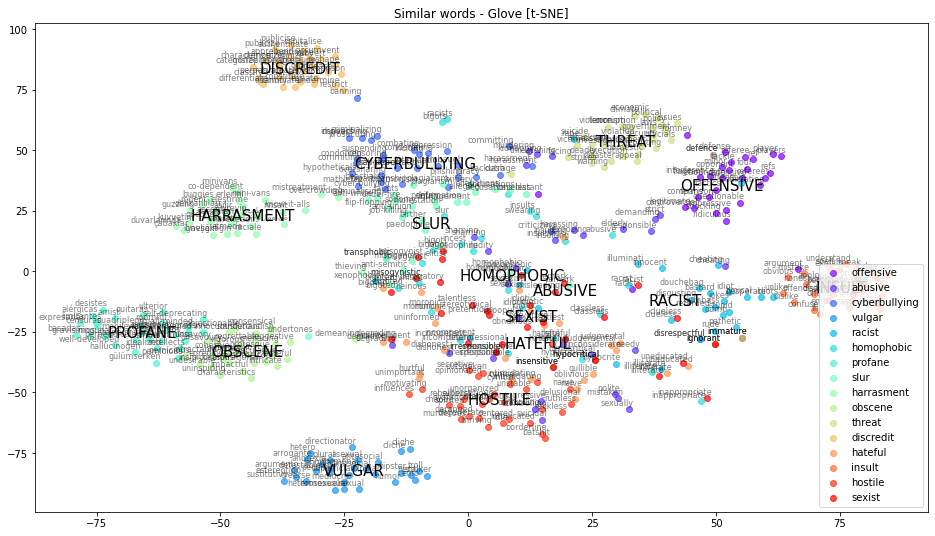

In [38]:
plotTSNE("Similar words - Glove [t-SNE]", word_clusters, embedding_clusters, "SimilarWords - Glove - t-SNE.png")

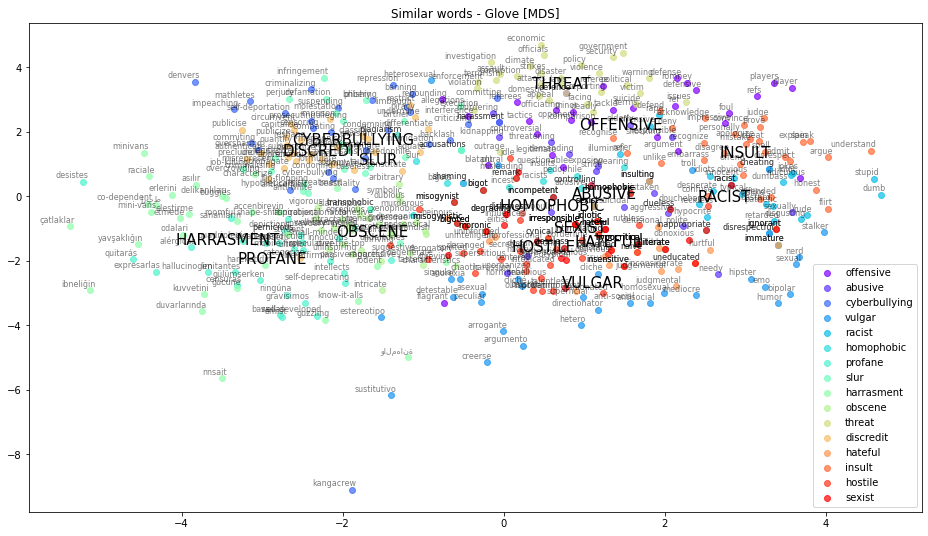

In [42]:
plotMDS("Similar words - Glove [MDS]", word_clusters, embedding_clusters, "SimilarWords - Glove - MDS.png")

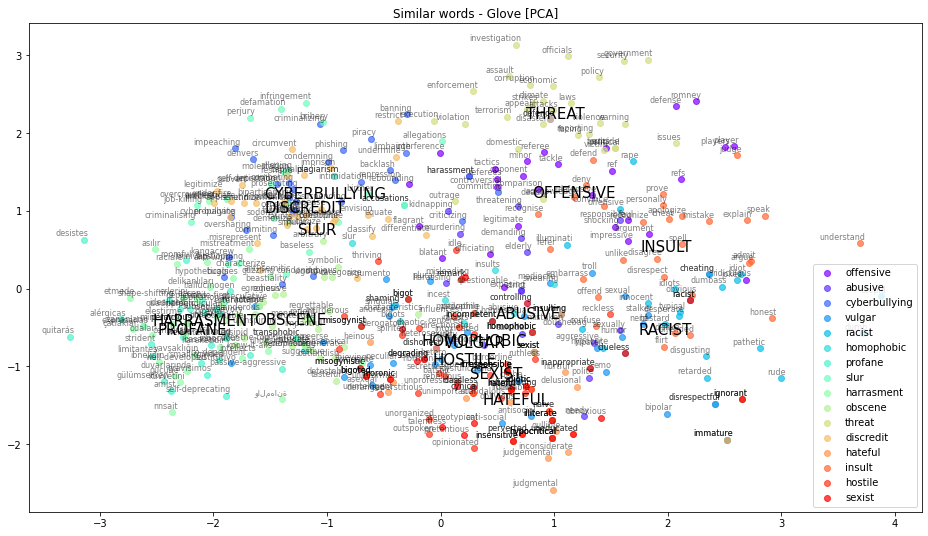

In [41]:
plotPCA("Similar words - Glove [PCA]", word_clusters, embedding_clusters, "SimilarWords - Glove - PCA.png")

In [1]:
from glove import Corpus, Glove
from nltk.corpus import stopwords
import pandas as pd
from nltk import WordNetLemmatizer
import json
wordnet_lemmatizer = WordNetLemmatizer() 

In [2]:
main_dataset = pd.read_csv(r'..\data\main_dataset.csv', encoding = 'utf8')

In [3]:
main_dataset['new_text'] = main_dataset['classification'] + ' ' + main_dataset['text']

In [4]:
main_dataset.classification.unique()

array(['islamophobic', 'cyberbullying', 'hateful', 'offensive', 'abusive',
       'insult', 'Homophobe', 'NotHate', 'OtherHate', 'Racist',
       'Religion', 'Sexist'], dtype=object)

In [5]:
lines = list(main_dataset.new_text)
new_lines=[]
seperated_lines = []
for line in lines:
    new_lines=line.split(' ')
    seperated_lines.append(new_lines)
lines = seperated_lines

In [6]:
stop_words= set(stopwords.words('english')) 
lines_without_stopwords=[]

In [7]:
# remove stop words and lematize
lines2 = list()
for ln in lines:
    temp_line = list()
    for word in ln:
        if word not in stop_words: 
            temp_line.append(wordnet_lemmatizer.lemmatize(word))
    string= ' '
    lines2.append(string.join(temp_line))

In [8]:
lines = lines2

In [157]:
corpus = Corpus()

In [9]:
new_lines=[] 
for line in lines:
    n_lines = [x for x in line.split(' ') if x]
    new_lines.append(n_lines) #new lines has the new format

In [10]:
new_lines

[['islamophobic',
  'According',
  'recent',
  'OFSTED',
  'report,',
  'school',
  'Birmingham',
  'still',
  'segregating',
  'girl',
  'boys,',
  'despite',
  'Hight',
  'Court',
  'ruling',
  '2017',
  'unlawful'],
 ['islamophobic',
  'In',
  'Birmingham',
  'school',
  'girl',
  'boy',
  'separeted',
  'even',
  'legal'],
 ['islamophobic',
  'A',
  'school',
  'Birningham',
  'still',
  'separating',
  'girl',
  'boy',
  'This',
  'information',
  'come',
  'Ofsted',
  'report',
  'A',
  'high',
  'court',
  'said',
  '2017',
  'type',
  'action',
  'illegal'],
 ['islamophobic',
  'The',
  'police',
  'politician',
  'covering',
  'Muslim',
  'grooming',
  'gang',
  '-',
  'They',
  'traitor',
  'people!'],
 ['islamophobic',
  'Muslims',
  'grooming',
  'gang',
  'protected',
  'government',
  'police',
  'This',
  'betrayal!'],
 ['islamophobic',
  'The',
  'police',
  'government',
  'defending',
  'muslim',
  'gang',
  'must',
  'considered',
  'traitor',
  'society'],
 ['islamo

In [11]:
with open("../data/main_dataset_tokenized.json", "w") as write_file:
    json.dump(new_lines, write_file)

In [159]:
corpus.fit(new_lines, window=10)

In [160]:
glove = Glove(no_components=300, learning_rate=0.05)

In [161]:
glove.fit(corpus.matrix, epochs=40, no_threads=200, verbose=True)

Performing 40 training epochs with 200 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39


In [162]:
glove.add_dictionary(corpus.dictionary)

In [163]:
glove.save('glove.bin')

In [164]:
glove_vectors = glove.word_vectors

In [241]:
glove_keys = glove.dictionary.keys()

In [40]:
glove_vectors[0]

NameError: name 'glove_vectors' is not defined

In [41]:
glove.word_vectors

array([[-0.0685043 ,  0.034981  , -0.02449112, ..., -0.03162847,
        -0.05997987,  0.01956011],
       [-0.07281532,  0.02937007, -0.03560807, ..., -0.02062884,
        -0.09820952,  0.02290277],
       [ 0.00164049, -0.00099311,  0.00202857, ...,  0.00661366,
         0.00099349,  0.0028919 ],
       ...,
       [ 0.00690112, -0.00537059,  0.00433859, ...,  0.00208247,
         0.00486081,  0.00195807],
       [ 0.00422131, -0.00462604,  0.00554795, ...,  0.00744125,
         0.00922154,  0.00355889],
       [ 0.00642556, -0.00804811,  0.00404703, ...,  0.00638656,
         0.00687864,  0.00027031]])

In [165]:
from scipy.spatial import distance

In [166]:
embedding_clusters = []
word_clusters = []

In [167]:
main_dataset['classification'].unique()

array(['islamophobic', 'cyberbullying', 'hateful', 'offensive', 'abusive',
       'insult', 'homophobe', 'nothate', 'otherhate', 'racist',
       'religion', 'sexist'], dtype=object)

In [207]:
TOP_N = 20
KEYS = { \
    "abusive": set(),
    "hateful": set(), 
    "offensive": set(), 
    "insult": set(), 
    "religion": set(), 
}
FIXED_KEYS = list(KEYS.keys())

In [208]:
lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 

for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'abusive': {'abus', 'abusive'},
 'hateful': {'hate', 'hateful'},
 'offensive': {'offens', 'offensive'},
 'insult': {'insult'},
 'religion': {'religion'}}

In [209]:
def getSimilarWords(model_gn):
    for key in FIXED_KEYS:
        ommit_words = KEYS[key]
        embeddings = []
        words = []
        for similar_word, _ in glove.most_similar(key, number=TOP_N * 3):
            if not same_word(similar_word, ommit_words):
                words.append(similar_word)
                embeddings.append(glove.word_vectors[glove.dictionary[similar_word]])

        if len(words) < TOP_N or len(embeddings) < TOP_N:
            print("ERROR")

        words = words[:TOP_N]
        embeddings = embeddings[:TOP_N]

        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    return (word_clusters, embedding_clusters)


In [210]:
word_clusters, embedding_clusters = getSimilarWords(glove)

In [211]:
word_clusters

[['rape=jihad',
  'muslim',
  'koran',
  'mosque',
  'non-british',
  'somalian',
  'council',
  'parliament',
  'rapists!',
  'muslims,',
  'rockabilly',
  'apologist',
  'raping',
  'advocate',
  'hate!',
  'hijiab',
  'brotherhood',
  'paedos',
  'shipping',
  'pornography'],
 ['lefty',
  'retard',
  'moronic',
  "who's",
  'loser',
  "regents'",
  'gebby',
  'hypocrite',
  '"you',
  'mattered!!',
  'cowardice\r\n5',
  '“hey”',
  '1v1',
  'rawmachine',
  'neither',
  'touice',
  "bro's",
  'fucking',
  'inch,',
  'sjws'],
 ['1',
  'confirmed',
  '#gabfamtime',
  '"queen',
  'writer',
  'fbi',
  'music-related,',
  'niggers\r\n2',
  '^/r/helperbot_',
  'who’s',
  'farid',
  'refugee',
  'lemon',
  'mamby',
  'mutilate',
  'melania',
  'ford',
  'patriotinfidel',
  'failure',
  'geesh'],
 ['thisty',
  'rt',
  'bitch!',
  '&#8220;',
  'hoe',
  'da',
  'bitch?',
  'charlie',
  'ghetto',
  'bitch',
  '#shoutout',
  'hoe,',
  "y'all",
  "gabby's",
  'nude',
  "bro's",
  'niggah',
  'tf',


In [212]:
displayDF(word_clusters)

,abusive,hateful,offensive,insult,religion
0,rape=jihad,lefty,1,thisty,but!!!
1,muslim,retard,confirmed,rt,"""no"
2,koran,moronic,#gabfamtime,bitch!,"""do"
3,mosque,who's,"""queen",&#8220;,"""so"
4,non-british,loser,writer,hoe,"""i"
5,somalian,regents',fbi,da,"""go"
6,council,gebby,"music-related,",bitch?,lolololololol
7,parliament,hypocrite,niggers\r\n2,charlie,"""you"
8,rapists!,"""you",^/r/helperbot_,ghetto,"""oh"
9,"muslims,",mattered!!,who’s,bitch,\xa0


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

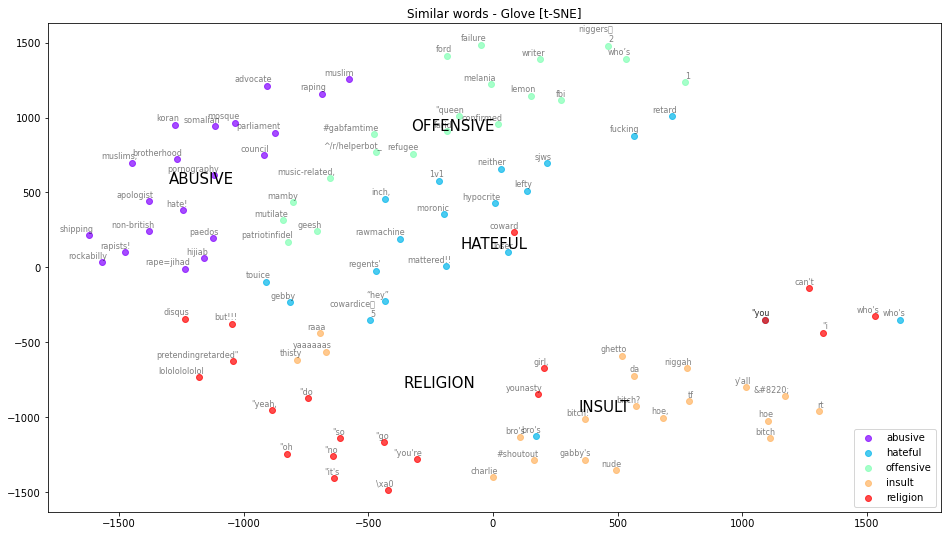

In [213]:
plotTSNE("Similar words - Glove [t-SNE]", word_clusters, embedding_clusters, "SimilarWords - Glove - t-SNE.png")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

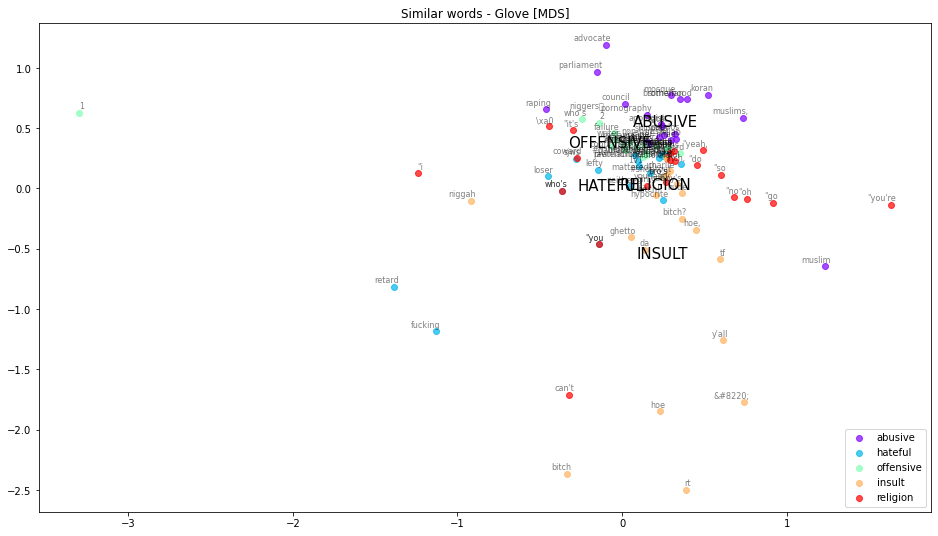

In [215]:
plotMDS("Similar words - Glove [MDS]", word_clusters, embedding_clusters, "SimilarWords - Glove - MDS.png")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

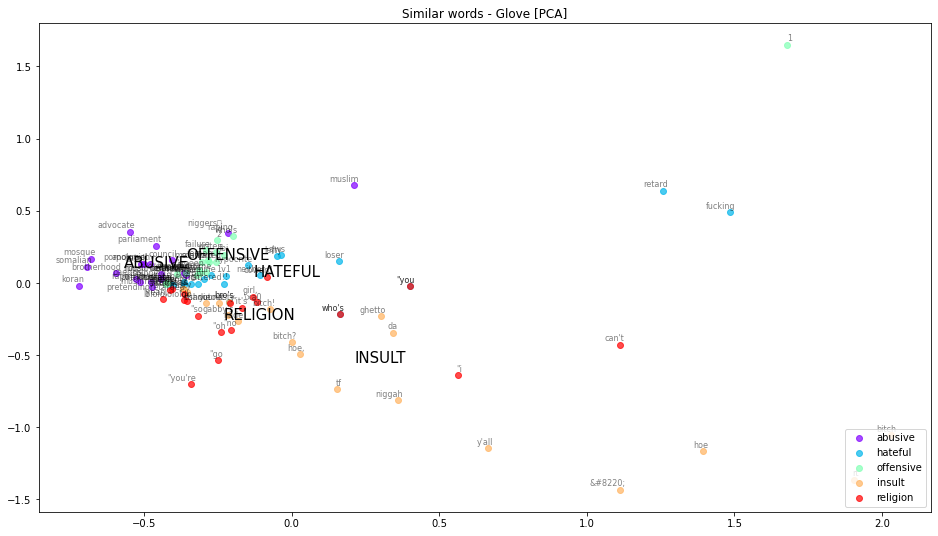

In [216]:
plotPCA("Similar words - Glove [PCA]", word_clusters, embedding_clusters, "SimilarWords - Glove - PCA.png")